# Neural Networks on MNIST

This Jupyter notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

## Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The cell below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

In [1]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')

    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

--2023-10-10 17:19:15--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 2606:4700:3036::ac43:ab4c, 2606:4700:3034::6815:1d24, 172.67.171.76, ...
Connecting to yann.lecun.com (yann.lecun.com)|2606:4700:3036::ac43:ab4c|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

     0K .......... .......... .......... .......... ..........  0%  298M 0s
    50K .......... .......... .......... .......... ..........  1% 5.61M 1s
   100K .......... .......... .......... .......... ..........  1% 5.97M 1s
   150K .......... .......... .......... .......... ..........  2% 98.3M 1s
   200K .......... .......... .......... .......... ..........  2% 86.0M 1s
   250K .......... .......... .......... .......... ..........  3%  320M 1s
   300K .......... .......... .......... .......... ..........  3% 6.26M 1s
   350K .......... .......... .......... ..

The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


### Install pytorch

In [2]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/08/aa/033a0a1bca4a3b8f81f97709024e053da37cf5c970f3dc5d76233c920b99/torchvision-0.16.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/5b/13/fcabc86948f9e89b62a538670720f8589d63f93d3f4f3d172236a98e70f8/torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/fe/d3/e1aa96437d944fbb9cc95d0316e25583886e9cd9e6adc07baad943524eda/fsspec-2023.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.4 MB/s eta 0:00:00m eta 0:00:010:00:01
  Obtainin

### Transformers

In [3]:

import re
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections import Counter
from typing import List, Tuple

class BeowulfDataset(Dataset):
    def __init__(self, file_path: str, sequence_length: int):
        # Read the text file
        with open(file_path, 'r') as f:
            text = f.read().lower()

        # Remove non-alphanumeric characters and tokenize
        self.tokens = re.sub(r'[^a-zA-Z0-9\s]', '', text).strip().split()

        # Build vocabulary
        self.vocab = {"<PAD>": 0, "<UNK>": 1}
        self.vocab.update({word: i for i, (word, _) in enumerate(Counter(self.tokens).items(), start=2)})
        self.token_ids = [self.vocab.get(token, self.vocab["<UNK>"]) for token in self.tokens]

        # Create input-output pairs using sliding window
        self.sequence_length = sequence_length
        self.pairs = [(self.token_ids[i:i+sequence_length-1], self.token_ids[i+sequence_length-1]) 
                      for i in range(len(self.token_ids) - sequence_length + 1)]

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        x, y = self.pairs[idx]
        return torch.tensor(x), torch.tensor(y)

    def num_unique_tokens(self):
        return len(self.vocab)
    
    def build_reverse_vocab(self):
        self.reverse_vocab = {i: word for word, i in self.vocab.items()}

    def tokens_to_text(self, tokens:torch.Tensor) -> str:
        """
        Convert a list of token IDs back to a string of text.
        """
        if not hasattr(self, "reverse_vocab"):
            self.build_reverse_vocab()
        if tokens.shape[0] == 1:
            tokens = [tokens.item()]
        else: 
            tokens = tokens.tolist()
        txt = [self.reverse_vocab[token] for token in tokens if token in self.reverse_vocab.keys()]
        return ' '.join(txt)
    
    def text_to_tokens(self, text: str) -> torch.Tensor:
        """
        Convert a list of token IDs back to a string of text.
        """
        txt = text.split(" ")
        token_ids = [self.vocab.get(token, self.vocab["<UNK>"]) for token in txt]
        out = torch.zeros(23)
        for i in range(min(out.shape[0], len(token_ids))):
            out[i] = token_ids[i]
        return out


file_path = 'beowulf.txt'
batch_size = 128
shuffle = True
sequence_length = 24  # for example, predicting 10th word based on previous 9 words

dataset = BeowulfDataset(file_path, sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Example usage:
print(f"Number of unique tokens in the dataset: {dataset.num_unique_tokens()}")



uniques = dataset.num_unique_tokens()
print(uniques)
words = list(set(dataset.vocab))



Number of unique tokens in the dataset: 37834
37834


In [4]:

import math




class self_attention(nn.Module):
  def __init__(self, device="cuda:0"):
    super().__init__()
    self.num_words = 12
    self.num_dims = 12

    self.pos_encoding = torch.zeros((self.num_words,self.num_dims))

    for pos in range(self.num_words):
      for i in range(self.num_dims):
        if pos % 2 == 0:
          self.pos_encoding[pos,i] = math.sin(pos/math.pow(10000, i/self.num_dims))
        else:
          self.pos_encoding[pos,i] = math.cos(pos/math.pow(10000, i-1/self.num_dims))
    self.pos_encoding = self.pos_encoding.to(device)

    self.Q = nn.Linear(self.num_dims, self.num_dims).to(device)
    self.K = nn.Linear(self.num_dims, self.num_dims).to(device)
    self.V = nn.Linear(self.num_dims, self.num_dims).to(device)
    self.softmax = nn.Softmax(dim=0)
    self.embedding = nn.Embedding(519,self.num_dims).to(device)
    self.flatten = nn.Flatten(start_dim=0)
    self.preoutput = nn.Linear(self.num_words*self.num_dims,512).to(device)
    self.gelu = nn.GELU()
    self.output = nn.Linear(512, 519).to(device)

  def forward(self, x, device="cuda:0"):
    x = x.to(device)
    x = self.embedding(x)
    x += self.pos_encoding
    x_q = self.Q(x)
    x_k = self.K(x)
    x_v = self.V(x)
    x_qk =  x_q.matmul(x_k.transpose(0,1))/math.sqrt(self.num_dims)
    x = self.softmax(x_qk)*x_v
    x = self.flatten(x)
    x=self.preoutput(x)
    x = self.gelu(x)
    x = self.output(x)

    return x

torch.manual_seed(0)
self_atten = self_attention()

#p = self_atten(numdata[:12])

optimizer = torch.optim.Adam(self_atten.parameters(), lr = 0.0001)
loss = nn.CrossEntropyLoss()

for k in range(50):
  loss_n = 0
  for batch, i in enumerate(dataloader):
    optimizer.zero_grad()
    x = batch
    y = torch.zeros(uniques)
    y = y.to("cuda:0")
    y[numdata[i+12]] = 1
    y_p = self_atten(x)
    l = loss(y_p, y)
    l.backward()
    optimizer.step()
    loss_n += l
  loss_n /= len(numdata)-13
  print("epoch:", k ,"loss:", loss_n)


#p = self_atten(numdata[:12])

#print(p, words[p.argmax()], data[13])

accuracy = 0
for i in range(len(numdata)-13):
  x = numdata[i:i+12]
  y = data[i+12]
  y_p = self_atten(x)
  y_p = y_p.to("cpu")
  #print(y, words[y_p.argmax()])
  if y != words[y_p.argmax()]:
    print("Wrong!")
  else:
    accuracy += 1
accuracy /= len(numdata)-13
print("accuracy:", accuracy)







NameError: name 'numdata' is not defined

it: 8554/8554, loss: 6.186310768127441, acc: 0.2624795417348609epoch: 0 loss: tensor(6.1863, device='cuda:0', grad_fn=<DivBackward0>) acc: 0.2624795417348609
it: 8554/8554, loss: 6.084527969360352, acc: 0.33421217954130183epoch: 1 loss: tensor(6.0845, device='cuda:0', grad_fn=<DivBackward0>) acc: 0.33421217954130183
it: 8554/8554, loss: 6.0768961906433105, acc: 0.3826532110275461epoch: 2 loss: tensor(6.0769, device='cuda:0', grad_fn=<DivBackward0>) acc: 0.3826532110275461
it: 8554/8554, loss: 6.076301574707031, acc: 0.47145412396409736epoch: 3 loss: tensor(6.0763, device='cuda:0', grad_fn=<DivBackward0>) acc: 0.47145412396409736
it: 8554/8554, loss: 6.0742340087890625, acc: 0.4930210525290312epoch: 4 loss: tensor(6.0742, device='cuda:0', grad_fn=<DivBackward0>) acc: 0.4930210525290312
it: 8554/8554, loss: 6.0730061531066895, acc: 0.5999751578209025epoch: 5 loss: tensor(6.0730, device='cuda:0', grad_fn=<DivBackward0>) acc: 0.5999751578209025
it: 8554/8554, loss: 6.069760799407959, acc: 

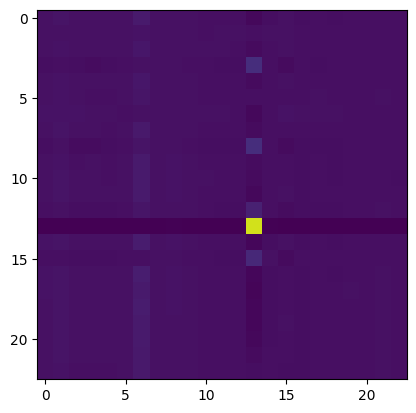

torch.Size([1, 8, 23, 23])


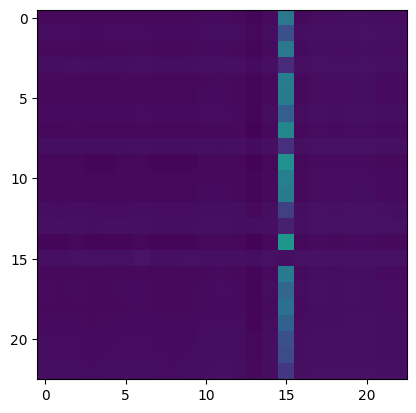

torch.Size([1, 8, 23, 23])


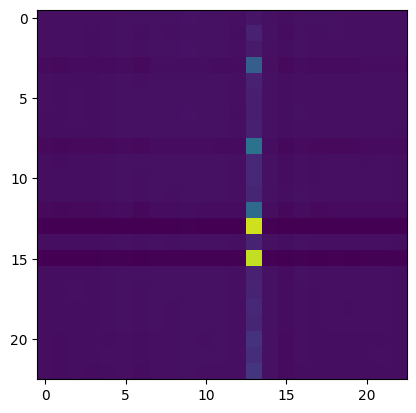

torch.Size([1, 8, 23, 23])


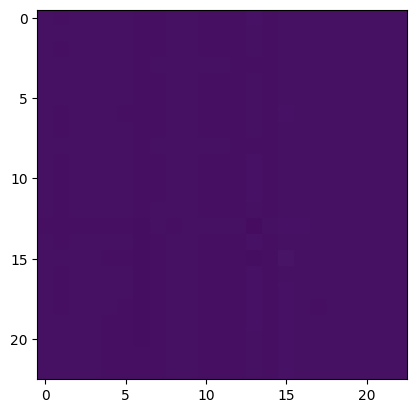

torch.Size([1, 8, 23, 23])


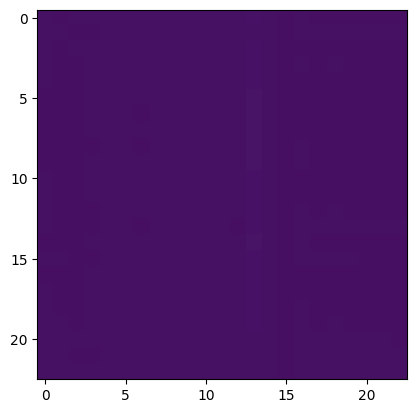

torch.Size([1, 8, 23, 23])


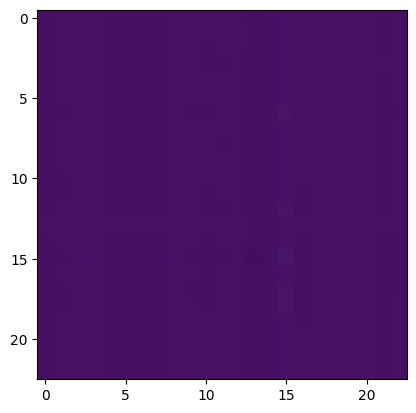

torch.Size([1, 8, 23, 23])


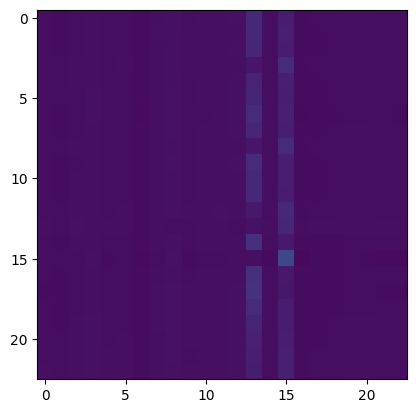

torch.Size([1, 8, 23, 23])


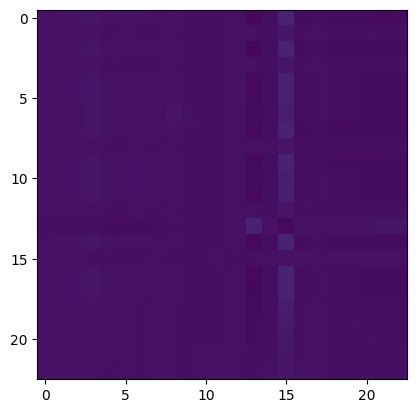

torch.Size([1, 8, 23, 23])
torch.Size([1, 8, 23, 23])


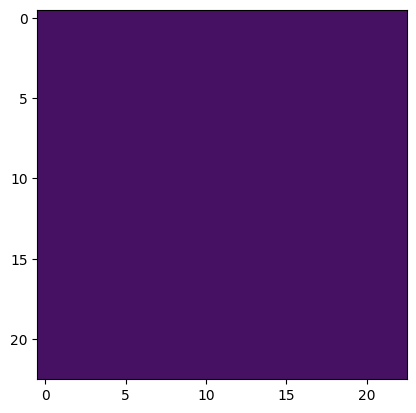

torch.Size([1, 8, 23, 23])


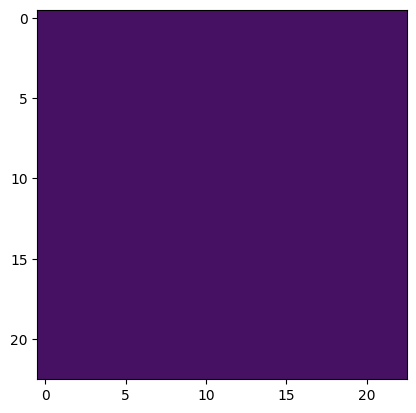

torch.Size([1, 8, 23, 23])


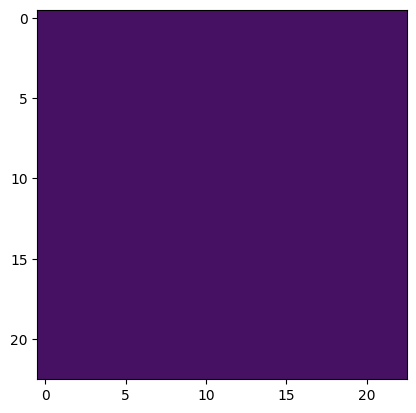

torch.Size([1, 8, 23, 23])


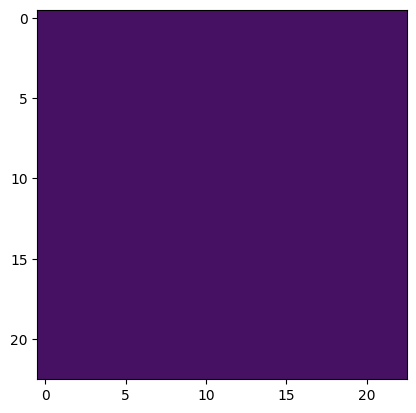

torch.Size([1, 8, 23, 23])


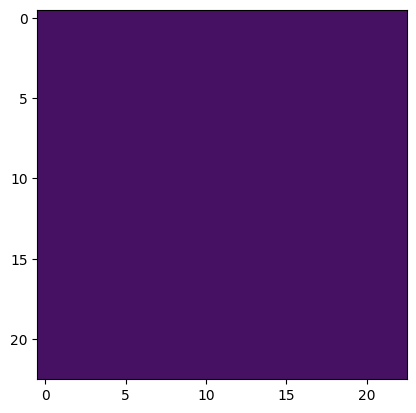

torch.Size([1, 8, 23, 23])


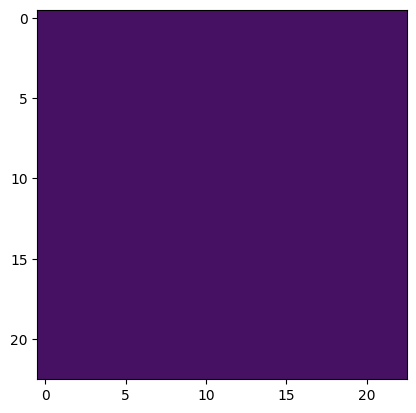

torch.Size([1, 8, 23, 23])


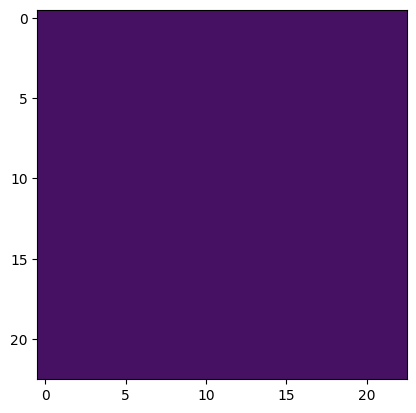

torch.Size([1, 8, 23, 23])


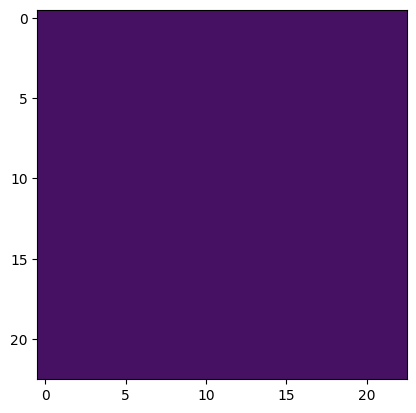

torch.Size([1, 8, 23, 23])
torch.Size([1, 8, 23, 23])


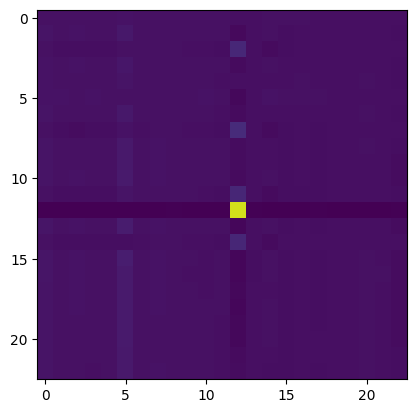

torch.Size([1, 8, 23, 23])


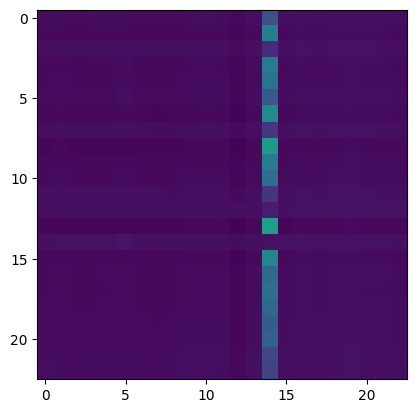

torch.Size([1, 8, 23, 23])


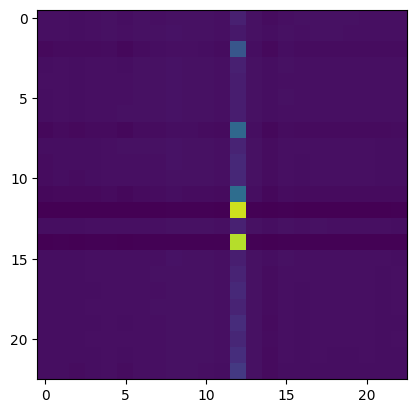

torch.Size([1, 8, 23, 23])


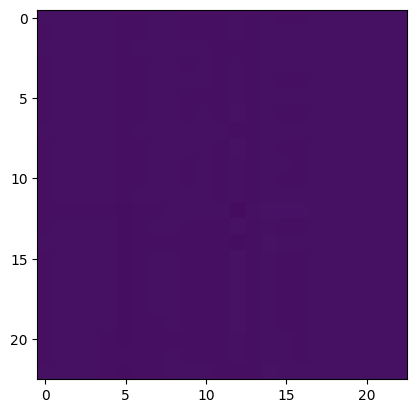

torch.Size([1, 8, 23, 23])


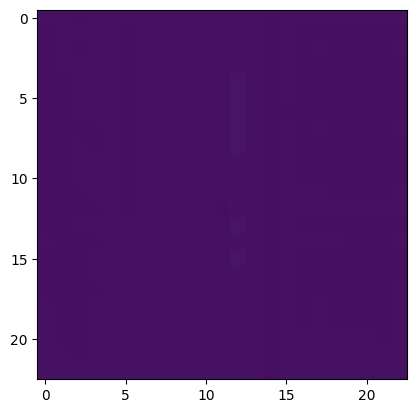

torch.Size([1, 8, 23, 23])


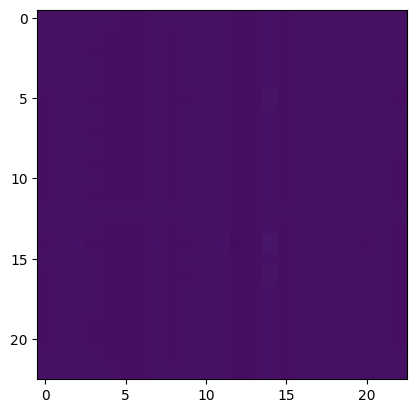

torch.Size([1, 8, 23, 23])


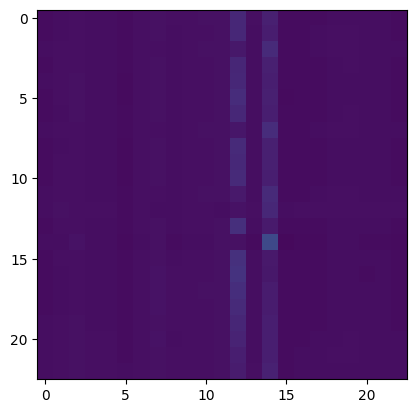

torch.Size([1, 8, 23, 23])


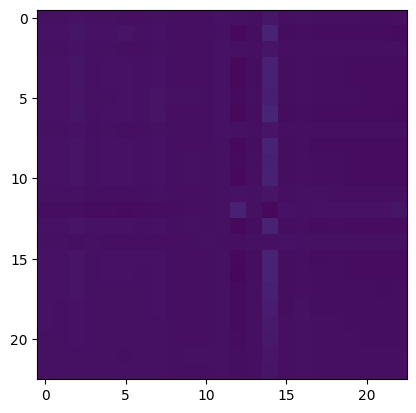

torch.Size([1, 8, 23, 23])
torch.Size([1, 8, 23, 23])


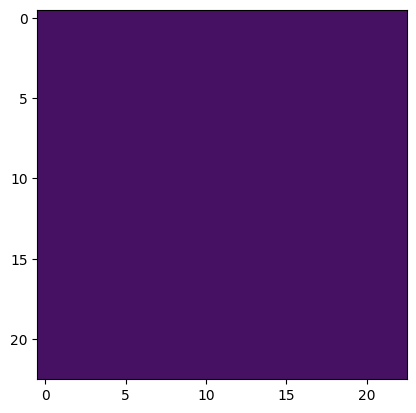

torch.Size([1, 8, 23, 23])


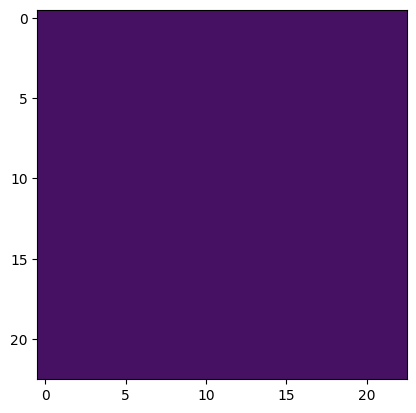

torch.Size([1, 8, 23, 23])


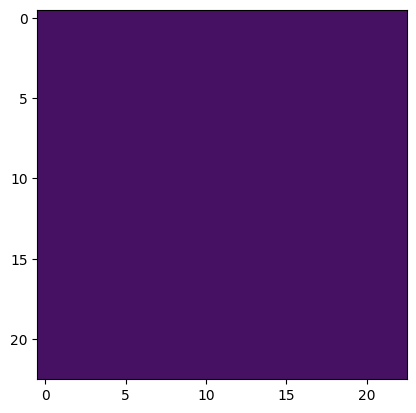

torch.Size([1, 8, 23, 23])


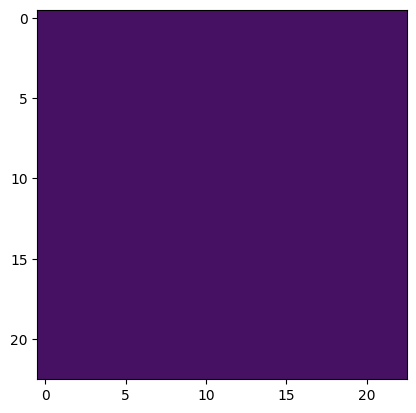

torch.Size([1, 8, 23, 23])


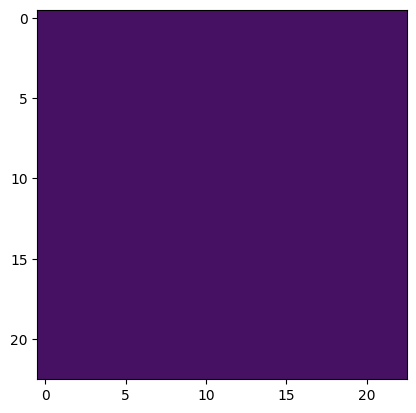

torch.Size([1, 8, 23, 23])


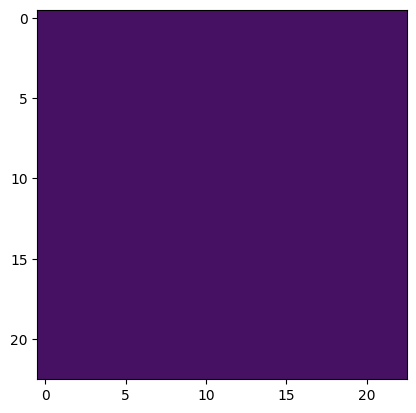

torch.Size([1, 8, 23, 23])


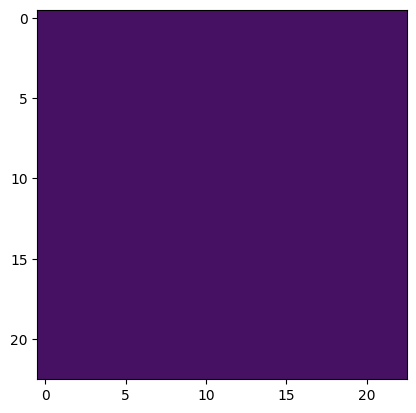

torch.Size([1, 8, 23, 23])


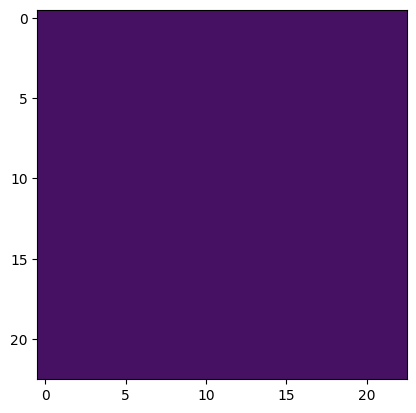

torch.Size([1, 8, 23, 23])


tensor([[-7.9647, -7.9647,  3.8007,  ..., -6.2867, -6.0678, -5.7902]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [5]:
import math
from matplotlib import pyplot as plt
#torch.manual_seed(0)
class self_attention_pure(nn.Module):
  def __init__(self, device="cuda:0", p_in=12, mid = 512, dims=0, num_heads=4):
    super().__init__()
    self.num_words = p_in
    self.num_dims = p_in
    self.num_heads = num_heads
    if dims != 0:
      self.num_dims = dims
    if self.num_dims % num_heads  != 0:
      raise "num heads must divide num dims"

    self.Q = nn.Linear(self.num_dims, self.num_dims).to(device)
    self.K = nn.Linear(self.num_dims, self.num_dims).to(device)
    self.V = nn.Linear(self.num_dims, self.num_dims).to(device)
    self.softmax = nn.Softmax(dim=3)
    self.preoutput_0 = nn.Linear(self.num_dims,mid).to(device)
    self.preoutput_1 = nn.Linear(mid, self.num_dims).to(device)
    self.gelu = nn.GELU()
    self.device=device


  def forward(self, x, device="cuda:0", visualization=False):
    x = x.to(self.device)
    id = x
    x_q = self.Q(x).view(x.shape[0], self.num_words, self.num_heads, self.num_dims//self.num_heads)
    x_k = self.K(x).view(x.shape[0], self.num_words, self.num_heads, self.num_dims//self.num_heads)
    x_v = self.V(x).view(x.shape[0], self.num_words, self.num_heads, self.num_dims//self.num_heads)
    x_q = x_q.permute(0, 2,1,3)
    x_k = x_k.permute(0, 2,1,3)
    x_v = x_v.permute(0, 2,1,3)

    x_qk = x_q.matmul(x_k.transpose(2,3))/math.sqrt(self.num_dims)
    x = self.softmax(x_qk).matmul(x_v)
    if visualization:
      vis_softmax = nn.Softmax(dim=1)
      for i in range(x_qk.shape[1]):
        print(x_qk.shape)
        plt.imshow(vis_softmax(x_qk[0][i]).clone().detach().cpu(), vmin=0, vmax=1)
        plt.show()
      print(self.softmax(x_qk).shape)
    x = x.permute(0, 2, 1, 3)
    x = x.reshape(x.shape[0], self.num_words, self.num_dims)
    x = self.preoutput_0(x)
    x = self.preoutput_1(x)
    x += id
    x = self.gelu(x)

    return x


class self_attention_w_pos_enc(nn.Module):
  def __init__(self, device="cuda:0", words = 12, dims = 12):
    super().__init__()
    self.num_words = words
    self.num_dims = dims
    self.embedding = nn.Embedding(uniques,self.num_dims).to(device)
    self.pos_encoding = torch.zeros((self.num_words,self.num_dims))

    for i in range(self.num_words):
      for j in range(self.num_dims):
        if j % 2 == 0:
          self.pos_encoding[i,j] = math.sin(i/math.pow(10000, j/self.num_dims))
        else:
          self.pos_encoding[i,j] = math.cos(i/math.pow(10000, j-1/self.num_dims))
    self.pos_encoding = self.pos_encoding.to(device)

    self.attention = self_attention_pure(device=device, p_in = self.num_dims, dims = self.num_dims, mid=512)
    self.output = nn.Linear(512, 519).to(device)

  def forward(self, x, device="cuda:0", visualization=False):
    x = x.to(device)
    x = self.embedding(x)
    x += self.pos_encoding
    x = self.attention(x, visualization=visualization)
    x = self.output(x)

    return x

class self_attention_w_pos_enc_pure(nn.Module):
  def __init__(self, device="cuda:0", num_words = 12, num_dims=12, out=512, num_heads=4):
    super().__init__()
    self.num_words = num_words
    self.num_dims = num_dims
    self.embedding = nn.Embedding(uniques,self.num_dims).to(device)
    self.pos_encoding = torch.zeros((self.num_words,self.num_dims))
    self.device=device

    for i in range(self.num_words):
      for j in range(self.num_dims):
        if j % 2 == 0:
          self.pos_encoding[i,j] = math.sin(i/math.pow(10000, j/self.num_dims))
        else:
          self.pos_encoding[i,j] = math.cos(i/math.pow(10000, (j-1)/self.num_dims))
    self.pos_encoding = self.pos_encoding.to(device)

    self.attention = self_attention_pure(device=device, p_in = self.num_words, dims = self.num_dims, mid=out, num_heads=num_heads)

  def forward(self, x, device="cuda:0", visualization=False):
    x = x.to(self.device)
    x = self.embedding(x)
    x += self.pos_encoding
    x = self.attention(x, visualization=visualization)
    return x


class multi_layer_self_attention(nn.Module):
  def __init__(self, device="cuda:0", outs=[144,256,512,519], seq_length=12, dims=12, num_heads=4):
    super().__init__()
    self.attention_w_enc = self_attention_w_pos_enc_pure(device=device, num_words=seq_length, num_dims=dims, out=outs[0], num_heads=num_heads)
    self.attention_1 = self_attention_pure(device=device, p_in=seq_length, dims=dims, mid=outs[0], num_heads=num_heads)
    self.attention_2 = self_attention_pure(device=device, p_in=seq_length, dims=dims, mid=outs[1], num_heads=num_heads)
    self.attention_3 = self_attention_pure(device=device, p_in=seq_length, dims=dims, mid=outs[2], num_heads=num_heads)
    self.linear_1 = nn.Linear(seq_length*dims, outs[0]).to(device)
    self.linear_2 = nn.Linear(outs[0], outs[1]).to(device)
    self.flatten = nn.Flatten(start_dim=1)
    self.output = nn.Linear(outs[1], outs[3]).to(device)
    self.device=device

  def forward(self, x, visualization=False):
    x = x.to(self.device)
    x = self.attention_w_enc(x, visualization=visualization)
    x = self.attention_1(x, visualization=visualization)
    x = self.attention_2(x, visualization=False)
    x = self.attention_3(x, visualization=False)

    x = self.flatten(x)
    x = self.linear_1(x)
    x = self.linear_2(x)
    x = self.output(x)
    return x

seq_length = sequence_length - 1
self_atten = multi_layer_self_attention(seq_length=seq_length, dims=256, num_heads=8, outs=[768,1024,512,uniques])
#p = self_atten(numdata[:12])

optimizer = torch.optim.Adam(self_atten.parameters(), lr = 0.00001, weight_decay=0.000005)
loss = nn.CrossEntropyLoss()
schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, cooldown=3, factor=0.333)



for k in range(25):
  loss_n = 0
  acc = 0
  for i, batch in enumerate(dataloader):
    optimizer.zero_grad()
    x = batch[0]
    y = torch.zeros((batch[1].shape[0], uniques))
    y = y.to("cuda:0")
    y[:,batch[1]] = 1
    y_p = self_atten(x, visualization=False)
    l = loss(y_p, y)
    l.backward()
    optimizer.step()
    loss_n += l/batch[0].shape[0]
    acc += torch.eq(y.argmax(dim=1), y_p.argmax(dim=1)).sum().item()/batch[0].shape[0]
    print(f"\rit: {i+1}/{len(dataloader)}, loss: {loss_n/(i+1)}, acc: {acc/(i+1)}", end="")
  loss_n /= len(dataloader)
  acc /= len(dataloader)
  schedule.step(loss_n)
  print("epoch:", k ,"loss:", loss_n, "acc:",acc)


#p = self_atten(numdata[:12])

#print(p, words[p.argmax()], data[13])

accuracy = 0
for i, batch in enumerate(dataloader):
  x = batch[0]
  y = torch.zeros((batch[1].shape[0], uniques))
  y[:,batch[1]] = 1
  y_p = self_atten(x, visualization=False)
  y_p = y_p.to("cpu")
  #print(y, words[y_p.argmax()])
  accuracy += torch.eq(y.argmax(dim=1), y_p.argmax(dim=1)).sum().item()/batch[0].shape[0]

accuracy /= len(dataloader)-seq_length-1
print("accuracy:", accuracy)

print(dataset.tokens_to_text(dataset[128][0]), dataset.tokens_to_text(torch.Tensor([dataset[128][1]])))
print(dataset[128][0].shape)
x = torch.Tensor(dataset[128][0]).unsqueeze(0)
self_atten(x, visualization=True)
x = torch.Tensor(dataset[129][0]).unsqueeze(0)
self_atten(x, visualization=True)


In [69]:
print(dataset.tokens_to_text(self_atten(dataset.text_to_tokens("i am a super person who went to school with bond and i ate two ice creams with potato sticks and sugar cane").to(torch.long).unsqueeze(0)).argmax(dim=1)))

the
